# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics.pairwise import laplacian_kernel

In [ ]:
SEED = 109
DELTA_PERCENTAGE = 95

# Preliminary: Updated Data Loading

## A

Importing Dataset

In [ ]:
#import urllib.request
csv_url = 'https://raw.githubusercontent.com/ItamarFriedman/HW3ML/main/data_HW3.csv'
dataset = pd.read_csv(csv_url)


## B

partitioning based on IDs

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size = 0.2, random_state = SEED)

## C (Data Preperation)

### Pre-processing

In [ ]:

# Transforms the feature "sex" from string to the boolean feature "is_male"
def transform_sex(dataset):
    is_male = dataset["sex"].isin(["M"])
    sexColIndex = dataset.columns.get_loc("sex")
    dataset.insert(sexColIndex, "is_male", is_male, False)
    dataset.drop(["sex"], axis=1, inplace=True)


# Transforms the feature "blood_type" from string the boolean feature "SpecialProperty"
def transform_blood_type(dataset):
    bloodTypeColIndex = dataset.columns.get_loc("blood_type")
    specialProperty = dataset["blood_type"].isin(["O+", "B+"])
    dataset.insert(bloodTypeColIndex, "SpecialProperty", specialProperty, False)
    dataset.drop(["blood_type"], axis=1, inplace=True)


# Transforms the feature "current_location" from string the continuous features "latitude" & "longitude"
def split_location(dataset):
    location_series = dataset['current_location'].astype(str).str.split("', '")
    latitude_series = location_series.str[0].str[2:].astype(float)
    longitude_series = location_series.str[1].str[:-2].astype(float)
    locationColIndex = dataset.columns.get_loc("current_location")
    dataset.insert(locationColIndex, "latitude", latitude_series, False)
    dataset.insert(locationColIndex+1, "longitude", longitude_series, False)
    dataset.drop(["current_location"], axis=1, inplace=True)


# Transforms the feature "symptoms" from string separate boolean features
def splitSymptomsToSeparateColumns(dataset):
    sore_throat = dataset["symptoms"].str.contains("sore_throat", na=False)
    cough = dataset["symptoms"].str.contains("cough", na=False)
    shortness_of_breath = dataset["symptoms"].str.contains("shortness_of_breath", na=False)
    smell_loss = dataset["symptoms"].str.contains("smell_loss", na=False)
    fever = dataset["symptoms"].str.contains("fever", na=False)
    symptomsColIndex = dataset.columns.get_loc("symptoms")
    dataset.insert(symptomsColIndex, "sore_throat", sore_throat, False)
    dataset.insert(symptomsColIndex, "cough", cough, False)
    dataset.insert(symptomsColIndex, "shortness_of_breath", shortness_of_breath, False)
    dataset.insert(symptomsColIndex, "smell_loss", smell_loss, False)
    dataset.insert(symptomsColIndex, "fever", fever, False)
    dataset.drop(["symptoms"], axis=1, inplace=True)


# Transforms the feature "pcr_date" from string the ordinal feature "date_as_ordinal"
def pcr_date_toordinal(dataset):
    pcr_ordinal_date = [datetime.strptime(d, '%d-%m-%y').toordinal() for d in dataset["pcr_date"]]
    pd.Series(pcr_ordinal_date)
    pcrDateColIndex = dataset.columns.get_loc("pcr_date")
    dataset.insert(pcrDateColIndex + 1, "date_as_ordinal", pcr_ordinal_date, False)
    dataset.drop(["pcr_date"], axis=1, inplace=True)


# Converts all boolean features to int
def dataset_bool_to_int(dataset):
    for feature in dataset.columns.tolist():
        if dataset[feature].dtypes == "bool":
            dataset[feature] = dataset[feature].astype(int)


def prepare_data(training_data, new_data):
    # Creating copies of the datasets to be safe
    res = new_data.copy()
    model = training_data.copy()
    # Transforming all the features to numeric ones
    transform_sex(res)
    transform_sex(model)
    transform_blood_type(res)
    transform_blood_type(model)
    split_location(res)
    split_location(model)
    splitSymptomsToSeparateColumns(res)
    splitSymptomsToSeparateColumns(model)
    res.drop("pcr_date", axis = 1)
    #pcr_date_toordinal(res)
    #pcr_date_toordinal(model)
    dataset_bool_to_int(res)
    dataset_bool_to_int(model)
    # Choosing which feature should be normalized in which scaler
    normalized = ["risk", "spread", "contamination_level"]
    minMaxFeatures = ["patient_id", "PCR_01", "PCR_02", "PCR_03", "PCR_05", "PCR_06", "is_male",
                      "SpecialProperty", "fever", "smell_loss", "shortness_of_breath", "cough", "sore_throat"]
    standardFeatures = [x for x in model.columns if (x not in minMaxFeatures) and (x not in normalized)]
    # Setting up the 2 scalers
    minMaxScaler = MinMaxScaler(feature_range=(-1, 1), copy=False)
    standardScaler = StandardScaler(copy=False)
    # Fitting the scalers based on the model dataset
    minMaxScaler.fit(model[minMaxFeatures])
    standardScaler.fit(model[standardFeatures])
    res[minMaxFeatures] = minMaxScaler.transform(res[minMaxFeatures])
    res[standardFeatures] = standardScaler.transform(res[standardFeatures])
    return res


### Applying pre-processing

In [ ]:
test = prepare_data(train, test)
train = prepare_data(train, train)

# Section 1: Linear regression implementation

## Q3

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

trainFeatures = train.drop("contamination_level", axis=1)
trainTarget = train[["contamination_level"]]
regr = linear_model.LinearRegression()
regr.fit(trainFeatures, trainTarget)
pred = regr.predict(trainFeatures)
mean_squared_error(trainTarget, pred, multioutput = "raw_values")



array([3.77119249])

In [ ]:
targetDifference = np.abs(pred - (trainTarget))
targetDifference

,contamination_level
346,3.279118
1027,3.482409
126,0.350906
814,0.626048
908,1.365831
...,...
298,0.491180
319,0.016501
587,0.984634
399,2.105567


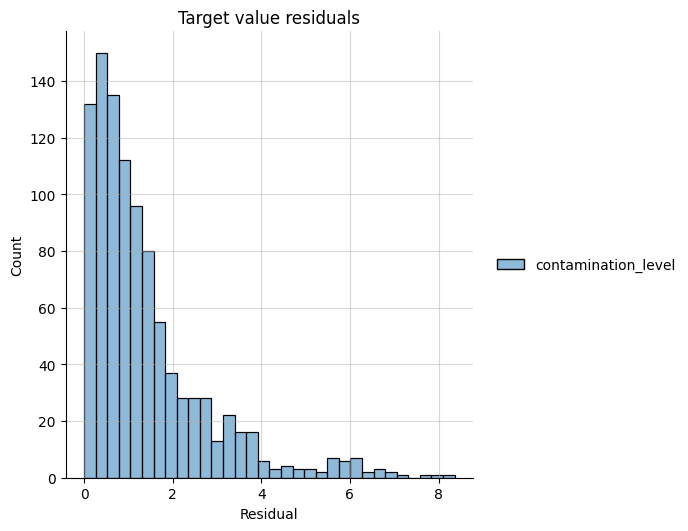

In [ ]:
sns.displot(targetDifference)
plt.title("Target value residuals")
plt.xlabel("Residual")
plt.grid(alpha = 0.5)

std dev is:  contamination_level    1.359084
dtype: float64 

95 % of the data, delta is: 4.016874369391776


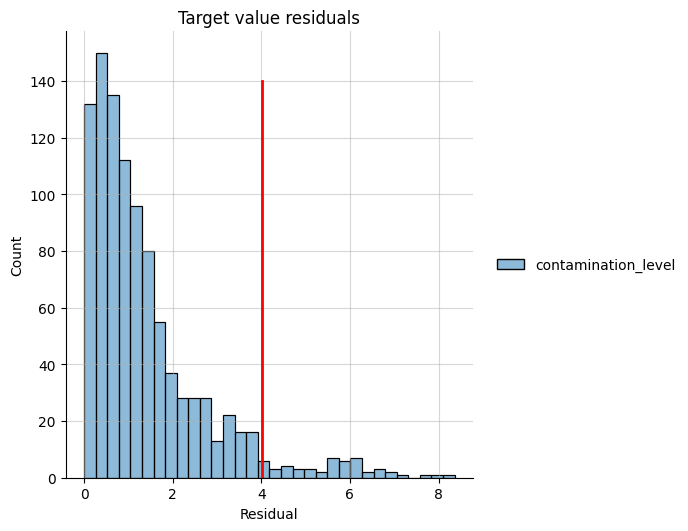

In [ ]:
percentage = DELTA_PERCENTAGE
standardDeviation = np.std(targetDifference)
print("std dev is: ", str(standardDeviation), "\n")
delta_zero = np.percentile(targetDifference, percentage)
print(percentage, "% of the data, delta is:", delta_zero)

sns.displot(targetDifference)
plt.title("Target value residuals")
plt.xlabel("Residual")
plt.grid(alpha = 0.5)
plt.plot([delta_zero, delta_zero],[0, 140], linewidth=2, color = 'r')

In [ ]:
PartOneTrain, PartOneValidation = train_test_split(train, test_size = 0.2, random_state = SEED)

###Linear regressor module

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np


class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5, huber_delta: float = 1.0):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0
        self.huber_delta = huber_delta

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y, huber_delta: float):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """
        # New version, not really necessary
        loss = abs(np.dot(X, w.reshape(X.shape[1],1)).reshape(y.shape) + b - y)
        lossSecondCopy = loss.copy()
        lossSecondCopy[loss <= huber_delta] = 0
        loss[loss > huber_delta] = 0
        loss = 0.5 * np.power(loss, 2)
        lossSecondCopy = np.multiply(np.sign(lossSecondCopy),(lossSecondCopy - 0.5 * huber_delta) * huber_delta)
        loss += lossSecondCopy

        loss = np.sum(loss) * (1 / len(y))
        return loss

        # old version
        '''
        loss = abs(np.dot(X, w).reshape(y.shape) + np.ones(len(y)).reshape(y.shape)*b - y)
        assert X.shape[0] == loss.shape[0], "size of loss got fucked up"
        lossCopy = loss.copy()
        lossSecondCopy = loss.copy()
        lossSecondCopy[loss <= huber_delta] = 0
        loss[loss > huber_delta] = 0
        loss = 0.5 * np.power(loss, 2)
        lossSecondCopy = np.multiply(np.sign(lossSecondCopy),(lossSecondCopy - 0.5 * huber_delta) * huber_delta)
        loss += lossSecondCopy

        for i, m in enumerate(loss):
          assert m >= 0
          if(lossCopy[i] <= huber_delta):
            assert loss[i] - (lossCopy[i]**2) * 0.5 <= 1e-6, "loss[i] is " + str(loss[i]) + "\n(lossCopy[i]**2) * 0.5 is " + str((lossCopy[i]**2) * 0.5)
          else:
            assert loss[i] == (lossCopy[i] - 0.5 * huber_delta) * huber_delta
        mInverseVector = (np.ones(y.size) / len(y))
        mInverseVector = mInverseVector.reshape(mInverseVector.shape[0],1)
        mInverseVector = mInverseVector.transpose()
        assert mInverseVector.shape == y.transpose().shape, "mInverse Is A BAD BOY" + str(mInverseVector.shape) + "!=" + str(y.transpose().shape)
        loss = np.dot(mInverseVector, loss).item()
        assert np.isscalar(loss), "np.dot(mInverseVector, loss) didn't work" + str(loss)
        return loss
        '''

    @staticmethod
    def gradient(w, b: float, X, y, huber_delta: float):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        loss = np.dot(X, w.reshape(X.shape[1],1)).reshape(X.shape[0], 1) + b - y
        lossCopy = loss.copy()
        loss[abs(loss) <= huber_delta] = 0
        loss = np.sign(loss) * (huber_delta / len(y))
        lossCopy[abs(lossCopy) > huber_delta] = 0
        lossCopy = lossCopy / y.size
        g_w = np.dot((loss + lossCopy).transpose(), X)  # Why in this order ??
        g_b = np.sum(loss + lossCopy)
        return g_w, g_b

        # old version
        '''
        loss = np.dot(X, w).reshape(X.shape[0], 1) + (np.ones(y.shape) * b) - y
        assert loss.shape ==  y.shape #X.shape[1]
        lossCopy = loss.copy()
        lossSecondCopy = loss.copy()
        lossThirdCopy = loss.copy()
        loss[abs(loss) <= huber_delta] = 0
        assert loss.shape == y.shape
        assert np.sign(loss).shape == y.shape
        loss = np.dot(X.transpose(), np.sign(loss)) * (huber_delta / len(y))
        lossCopy[abs(lossCopy) > huber_delta] = 0
        lossCopy = np.dot(X.transpose(), lossCopy)  / y.size
        g_w = loss + lossCopy
        #lossSecondCopy = lossSecondCopy.flatten()
        lossSecondCopy[lossSecondCopy > huber_delta] = huber_delta
        lossSecondCopy[lossSecondCopy < 0] = 0
        lossSecondCopy /= y.size
        g_b = np.sum(lossSecondCopy)
        return g_w, g_b
        '''

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y, self.huber_delta))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val, self.huber_delta))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y, self.huber_delta)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y, self.huber_delta))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val, self.huber_delta))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = np.dot(X, self.w.reshape(X.shape[1],1)) + self.b

        return y_pred

## Given verify_gradients

In [ ]:
def numerical_subgradient(w, b, X, y, huber_delta: float, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y, huber_delta) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, huber_delta: float, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y, huber_delta)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, huber_delta, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


## Q4

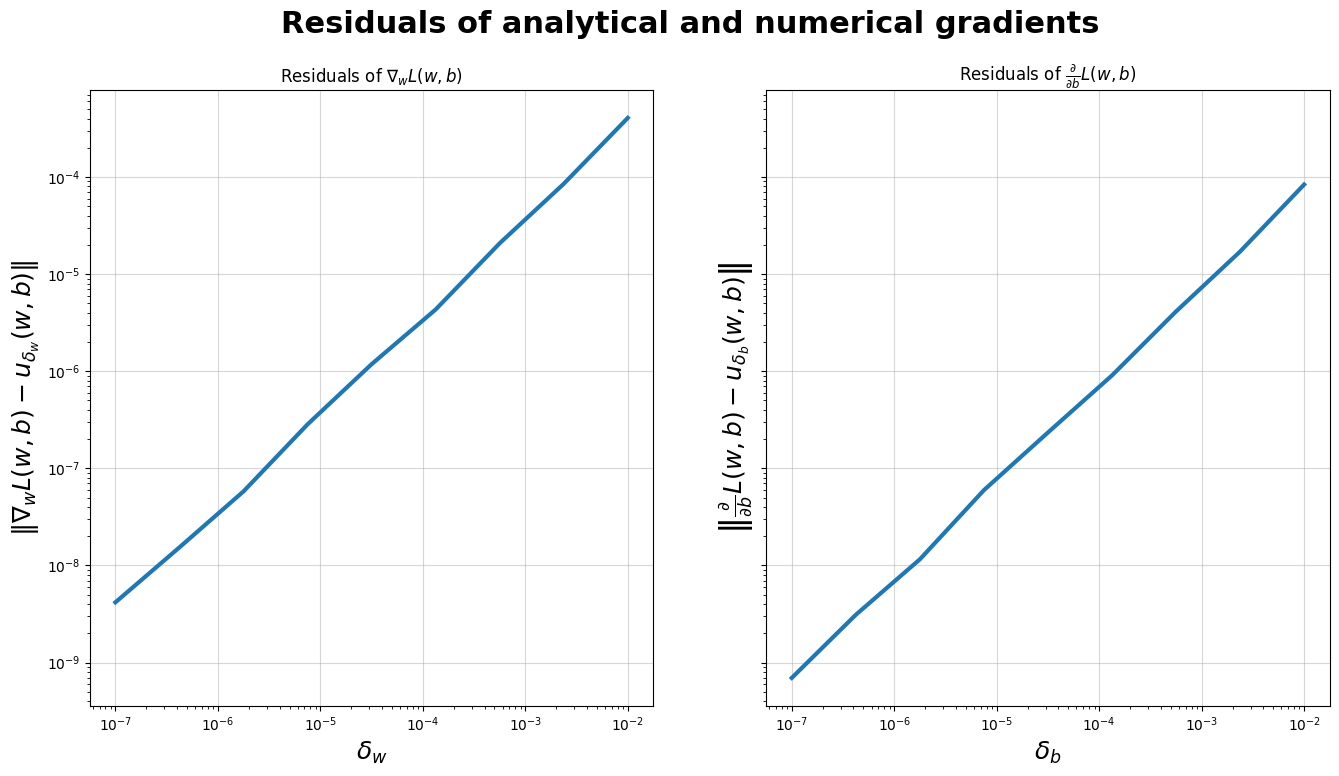

In [ ]:
huber_delta = 0.1
"""
trainFeatures = train.drop("contamination_level")
trainTarget =
"""
compare_gradients(trainFeatures.to_numpy(), trainTarget.to_numpy(), huber_delta, deltas=np.logspace(-7, -2, 9))

## test_lr.py

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def test_lr(X_train, y_train, X_val, y_val, huber_delta: float, title: str, max_iter: int = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr, huber_delta)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter=max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = ' + str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

##Q5

lr size = 1e-09, Best train loss = 2.816715787081232, Best validation loss = 3.182403693532927
lr size = 1e-08, Best train loss = 2.8166622600374023, Best validation loss = 3.1823597623619437
lr size = 1e-07, Best train loss = 2.816127190246673, Best validation loss = 3.181920620010401
lr size = 1e-06, Best train loss = 2.810796497646107, Best validation loss = 3.177546080710204
lr size = 1e-05, Best train loss = 2.7594320144480338, Best validation loss = 3.1354387069728786
lr size = 0.0001, Best train loss = 2.394829468192094, Best validation loss = 2.838721935588328
lr size = 0.001, Best train loss = 1.7806072131851056, Best validation loss = 2.341880225702321
lr size = 0.01, Best train loss = 1.6660379916352515, Best validation loss = 2.2754151286421296
lr size = 0.1, Best train loss = 1.6751562111447325, Best validation loss = 2.2392515683870746


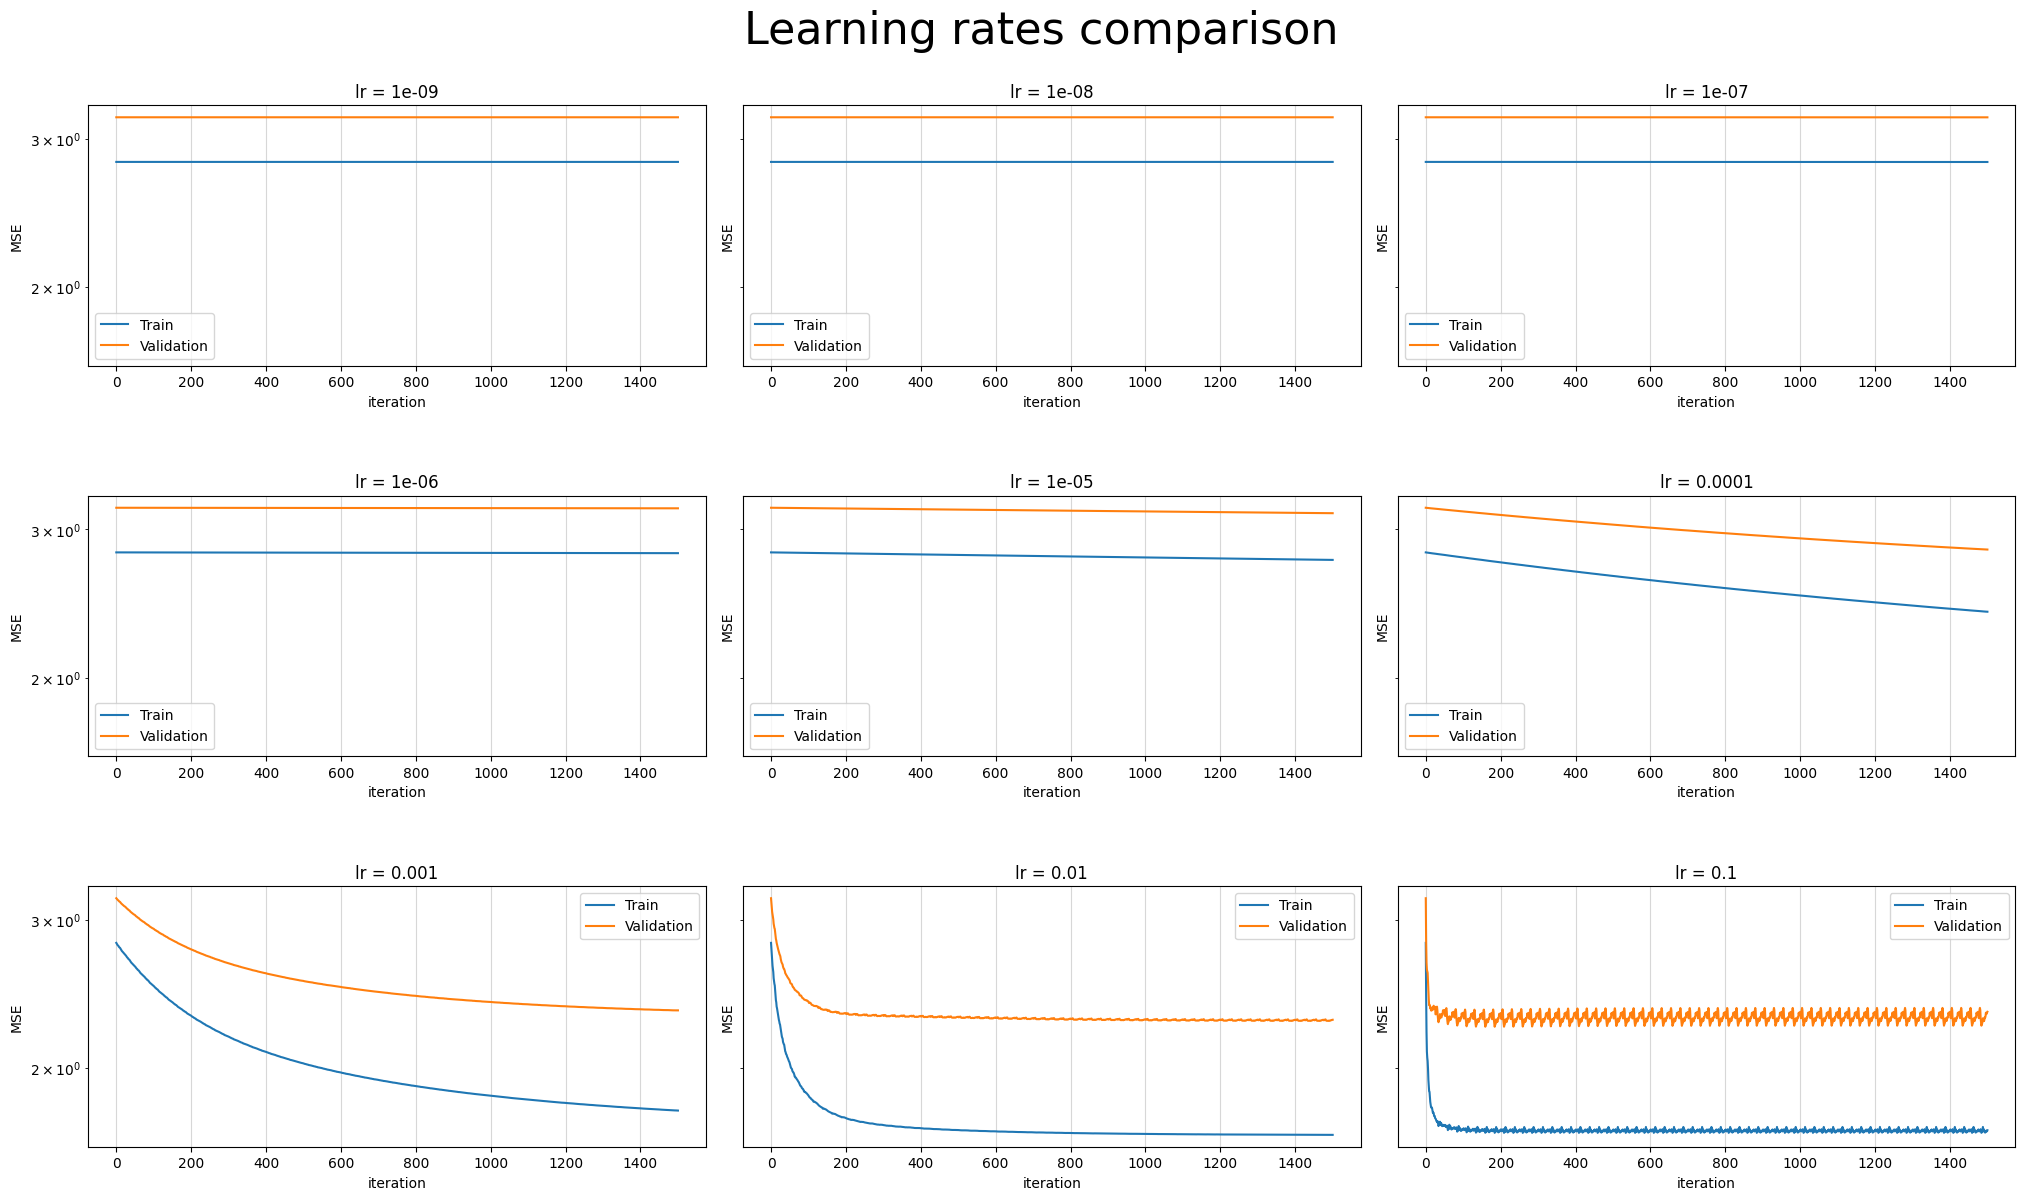

In [ ]:
X_train = PartOneTrain.drop("contamination_level", axis=1)
y_train = PartOneTrain[["contamination_level"]]
X_val = PartOneValidation.drop("contamination_level", axis=1)
y_val = PartOneValidation[["contamination_level"]]


test_lr(X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy(), delta_zero, "Learning rates comparison")
pass

#Section 2: Evaluation and Baseline

## Q7

In [ ]:
def huber_loss(y_true, y_pred, huber_delta = delta_zero):
  residuals =  np.abs(y_pred - y_true)
  residualsCopy = residuals.copy()
  residuals[residuals <= huber_delta] = 0
  residualsCopy[residualsCopy > huber_delta] = 0
  residualsCopy = 0.5 * residualsCopy**2
  reisuals = huber_delta * (residuals - 0.5*huber_delta)
  return np.mean(residuals + residualsCopy)


huber_scorer = make_scorer(huber_loss, greater_is_better = True)
mse_scorer = make_scorer(mean_squared_error,  greater_is_better = True)

doubleScoring = {"neg_mean_squared_error": mse_scorer, "huber_loss_error": huber_scorer}

In [ ]:
ourDummy = DummyRegressor()
cross_results = cross_validate(ourDummy, trainFeatures.to_numpy(), trainTarget.to_numpy(), scoring = doubleScoring, return_train_score = True)

for key,value in cross_results.items():
  print(str(key) + ":", np.mean(value))

dummyValidMSE = np.mean(cross_results["test_neg_mean_squared_error"])

fit_time: 0.0007553577423095703
score_time: 0.005144596099853516
test_neg_mean_squared_error: 5.353324622414092
train_neg_mean_squared_error: 5.327228884965285
test_huber_loss_error: 1.4913756466514771
train_huber_loss_error: 1.4793311883508717


In [ ]:
ourDummy.fit(trainFeatures, trainTarget)

DummyRegressor()

In [ ]:
print(ourDummy.constant_)
print(np.mean(trainTarget["contamination_level"]))

[[1.2917444]]
1.2917443983260035


In [ ]:
ourDummy.predict([0.5])

array([1.2917444])

## Q8

In [ ]:
logs =  np.logspace(-0.2,-7,32)
regressors = [LinearRegressor(lr=log, huber_delta=delta_zero) for log in logs]

crossVals = [cross_validate(regressor, trainFeatures.to_numpy(), trainTarget.to_numpy(), scoring=doubleScoring, return_train_score=True) \
            for regressor in regressors]

print(logs)

[6.30957344e-01 3.80754602e-01 2.29768412e-01 1.38654984e-01
 8.36720954e-02 5.04923759e-02 3.04698957e-02 1.83872224e-02
 1.10958682e-02 6.69586134e-03 4.04065353e-03 2.43835410e-03
 1.47143789e-03 8.87947107e-04 5.35836456e-04 3.23353391e-04
 1.95129342e-04 1.17751851e-04 7.10579875e-05 4.28803246e-05
 2.58763625e-05 1.56152301e-05 9.42309454e-06 5.68641707e-06
 3.43149895e-06 2.07075650e-06 1.24960914e-06 7.54083355e-07
 4.55055655e-07 2.74605782e-07 1.65712336e-07 1.00000000e-07]


In [ ]:
def bestRegressor(crossVal, range, mse = False):
  i = 0
  bestTrain = (0, crossVals[0])
  bestVal = (0, crossVals[0])
  trainHuberLoss = []
  validMSE = []
  if mse:
    train_error = "train_neg_mean_squared_error"
  else:
    train_error = "train_huber_loss_error"
  # Choose Best Validation:
  for item in crossVals:
    if np.abs(np.mean(item[train_error])) <= np.abs(np.mean(bestTrain[1][train_error])):
      bestTrain = (range[i], item)
    if np.abs(np.mean(item["test_neg_mean_squared_error"])) <= np.abs(np.mean(bestVal[1]["test_neg_mean_squared_error"])):
      bestVal = (range[i], item)
    #print("\nLearning Rate=", logs[i])
    trainHuberLoss.append(np.mean(item[train_error]))
    validMSE.append(np.mean(item["test_neg_mean_squared_error"]))
    i += 1
  print("\nBest:\n")
  print("bestTrain:")
  print("range = ", bestTrain[0])
  for key,value in bestTrain[1].items():
    print(str(key) + ":", np.mean(value))
  print("\n")
  print("bestVal:")
  print("range = ", bestVal[0])
  for key,value in bestVal[1].items():
    print(str(key) + ":", np.mean(value))
  return bestVal[0], trainHuberLoss, validMSE

bestLearningRate, trainHuberLoss, validMSE = bestRegressor(crossVals, logs)



Best:

bestTrain:
range =  0.0008879471073367863
fit_time: 0.13647041320800782
score_time: 0.005589914321899414
test_neg_mean_squared_error: 4.587205459238144
train_neg_mean_squared_error: 4.476148173136947
test_huber_loss_error: 1.1824863506340513
train_huber_loss_error: 1.1564189083849652


bestVal:
range =  0.03046989570903508
fit_time: 0.08243031501770019
score_time: 0.0007174015045166016
test_neg_mean_squared_error: 4.013851094346933
train_neg_mean_squared_error: 3.783716622076169
test_huber_loss_error: 1.3033023904329704
train_huber_loss_error: 1.2493741619129413


Text(0, 0.5, 'Mean loss')

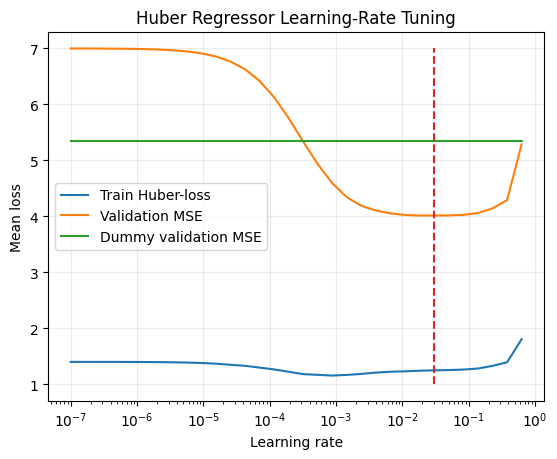

In [ ]:
plt.plot(logs, trainHuberLoss, label="Train Huber-loss")
plt.plot(logs, validMSE, label="Validation MSE")
plt.plot([logs[0],logs[-1]], [dummyValidMSE, dummyValidMSE], label = "Dummy validation MSE")
plt.plot([bestLearningRate, bestLearningRate],[1,7], linestyle="dashed")
plt.legend(loc="center left")
plt.xscale("log")
plt.grid(alpha = 0.25)
plt.title("Huber Regressor Learning-Rate Tuning")
plt.xlabel("Learning rate")
plt.ylabel("Mean loss")

##Q9

In [ ]:
tunedLinearModel = LinearRegressor(lr=bestLearningRate, huber_delta=delta_zero)
tunedLinearModel.fit(trainFeatures.to_numpy(), trainTarget.to_numpy())

LinearRegressor(huber_delta=4.016874369391776, lr=0.03046989570903508)

# Section 3: Ridge linear regression

##Q10

In [ ]:
lambda_range = sorted(list(range(1,400,5))+list(range(25,35,1))) #+list(np.logspace(-2,7, 40)))
huberRegressors = [HuberRegressor(epsilon = delta_zero, fit_intercept=True, alpha = lambdaValue) for lambdaValue in lambda_range]
crossVals = [cross_validate(regressor, trainFeatures.to_numpy(), trainTarget.values.ravel(), scoring=doubleScoring, return_train_score=True) \
            for regressor in huberRegressors]

In [ ]:
trainHuberLoss = []
validMSE = []
best_lambda, trainHuberLoss, validMSE = bestRegressor(crossVals, lambda_range)


Best:

bestTrain:
range =  191
fit_time: 0.0067004203796386715
score_time: 0.0005944252014160156
test_neg_mean_squared_error: 4.121389672534956
train_neg_mean_squared_error: 3.9658187943822996
test_huber_loss_error: 1.2621138182485931
train_huber_loss_error: 1.218314538521062


bestVal:
range =  33
fit_time: 0.011705112457275391
score_time: 0.0006659507751464843
test_neg_mean_squared_error: 3.9873571696545236
train_neg_mean_squared_error: 3.7628719562966553
test_huber_loss_error: 1.3462642684546196
train_huber_loss_error: 1.2902966846315205


Text(0, 0.5, 'Mean loss')

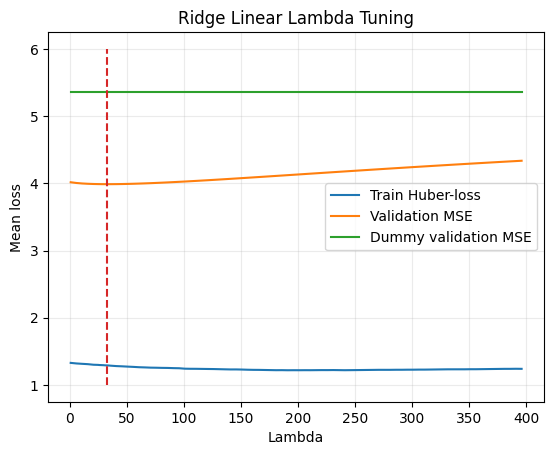

In [ ]:
plt.plot(lambda_range, trainHuberLoss, label="Train Huber-loss")
plt.plot(lambda_range, validMSE, label="Validation MSE")
plt.plot([lambda_range[0],lambda_range[-1]], [dummyValidMSE, dummyValidMSE], label = "Dummy validation MSE")
plt.plot([best_lambda, best_lambda],[1,6], linestyle="dashed")
plt.legend(loc="center right")
#plt.xscale("log")
plt.grid(alpha = 0.25)
plt.title("Ridge Linear Lambda Tuning")
plt.xlabel("Lambda")
plt.ylabel("Mean loss")

## Q10 copy with log axis

In [ ]:
lambda_range = sorted(list(range(1,400,5))+list(range(25,35,1))+list(np.logspace(-2,7,40))) #+list(np.logspace(-2,7, 40)))
huberRegressors = [HuberRegressor(epsilon = delta_zero, fit_intercept=True, alpha = lambdaValue) for lambdaValue in lambda_range]
crossVals = [cross_validate(regressor, trainFeatures.to_numpy(), trainTarget.values.ravel(), scoring=doubleScoring, return_train_score=True) \
            for regressor in huberRegressors]

In [ ]:
trainHuberLoss = []
validMSE = []
best_lambda, trainHuberLoss, validMSE = bestRegressor(crossVals, lambda_range)


Best:

bestTrain:
range =  191
fit_time: 0.007369041442871094
score_time: 0.000595855712890625
test_neg_mean_squared_error: 4.121389672534956
train_neg_mean_squared_error: 3.9658187943822996
test_huber_loss_error: 1.2621138182485931
train_huber_loss_error: 1.218314538521062


bestVal:
range =  33
fit_time: 0.010912895202636719
score_time: 0.0005838394165039063
test_neg_mean_squared_error: 3.9873571696545236
train_neg_mean_squared_error: 3.7628719562966553
test_huber_loss_error: 1.3462642684546196
train_huber_loss_error: 1.2902966846315205


Text(0, 0.5, 'Mean loss')

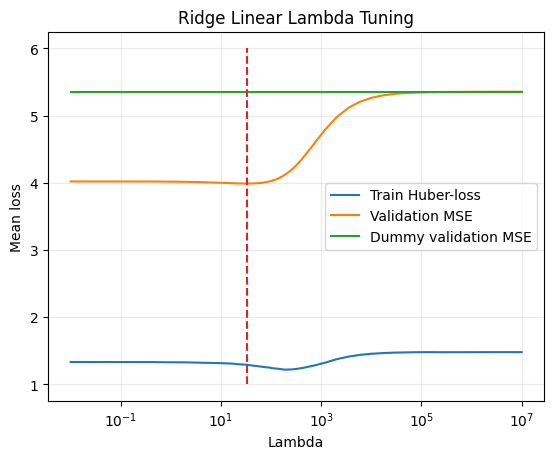

In [ ]:
plt.plot(lambda_range, trainHuberLoss, label="Train Huber-loss")
plt.plot(lambda_range, validMSE, label="Validation MSE")
plt.plot([lambda_range[0],lambda_range[-1]], [dummyValidMSE, dummyValidMSE], label = "Dummy validation MSE")
plt.plot([best_lambda, best_lambda],[1,6], linestyle="dashed")
plt.legend(loc="center right")
plt.xscale("log")
plt.grid(alpha = 0.25)
plt.title("Ridge Linear Lambda Tuning")
plt.xlabel("Lambda")
plt.ylabel("Mean loss")

## Q11

In [ ]:
tunedRidgeLinearModel = HuberRegressor(epsilon = delta_zero, fit_intercept=True, alpha = best_lambda)
tunedRidgeLinearModel.fit(trainFeatures.to_numpy(), trainTarget.values.ravel())

HuberRegressor(alpha=33, epsilon=4.016874369391776)

## Q12

Text(0, 0.5, 'Absolute value')

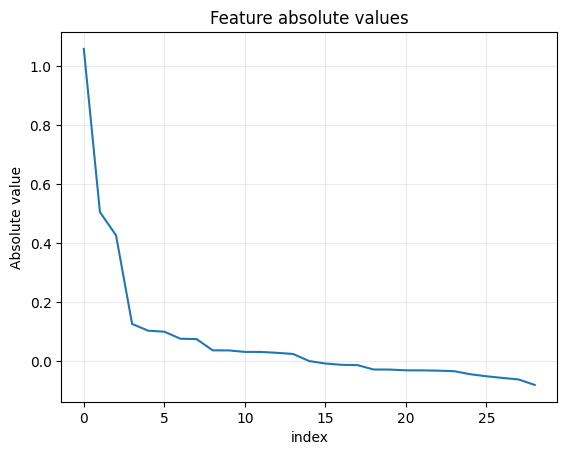

In [ ]:
plt.plot(sorted(tunedRidgeLinearModel.coef_, reverse = True))
plt.grid(alpha = 0.25)
plt.title("Feature absolute values")
plt.xlabel("index")
plt.ylabel("Absolute value")

# Section 4: Feature Mappings (visualization)

## task (only PCR_02 and PCR_03)

In [ ]:
sectionFourTrain = train[["PCR_02","PCR_06","contamination_level"]]
sectionFourTrain.head()

,PCR_02,PCR_06,contamination_level
346,0.173467,0.482787,6.676329
1027,0.452145,0.124378,6.567480
126,-0.713550,0.660515,0.001545
814,-0.179005,0.665173,0.000591
908,-0.921073,-0.413033,0.770319


## plot3d

In [ ]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

## task (ploting the dataset)

<ipython-input-35-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


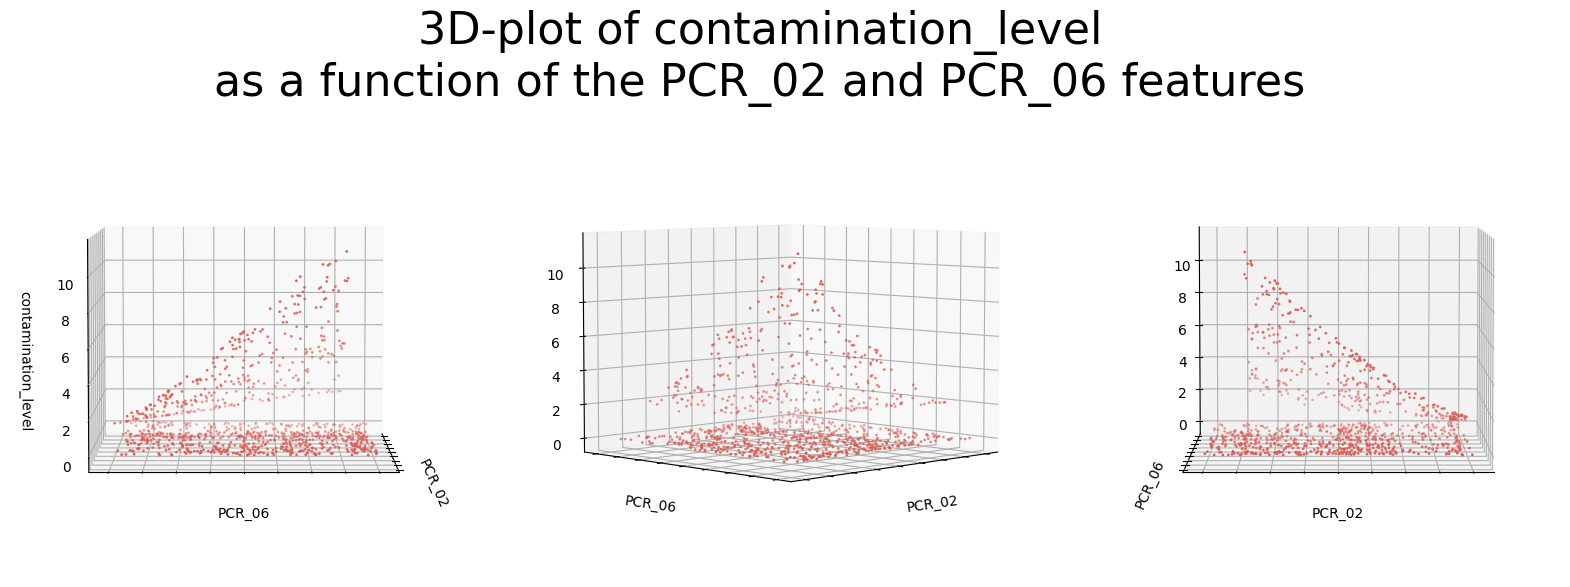

In [ ]:
plot3d(sectionFourTrain, "PCR_02", "PCR_06", "contamination_level", "3D-plot of contamination_level\nas a function of the PCR_02 and PCR_06 features")

## Q15

In [ ]:
partFourRegressor = HuberRegressor(epsilon = delta_zero, fit_intercept=True, alpha = best_lambda)
partFourRegressor.fit(sectionFourTrain.drop("contamination_level", axis=1), sectionFourTrain["contamination_level"].values.ravel())

HuberRegressor(alpha=33, epsilon=4.016874369391776)

## Q16

<ipython-input-35-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


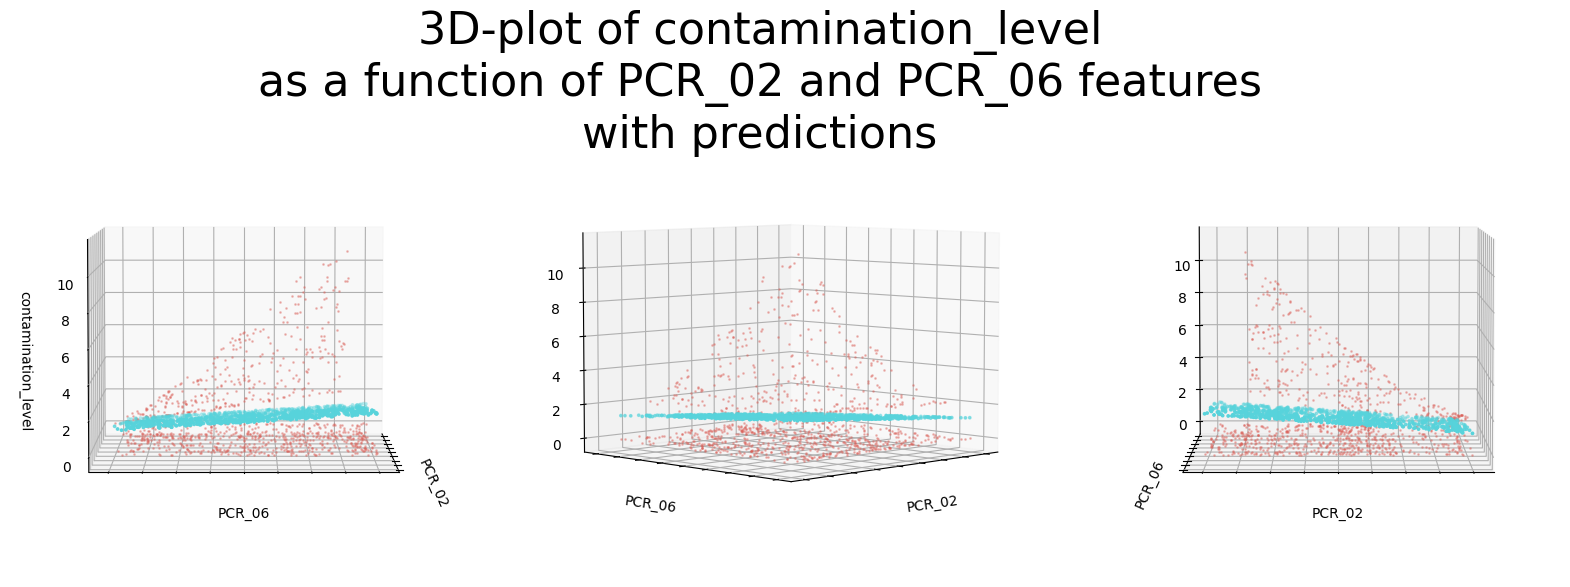

In [ ]:
partFourPredictions = partFourRegressor.predict(sectionFourTrain.drop("contamination_level", axis=1))
plot3d(sectionFourTrain, "PCR_02", "PCR_06", "contamination_level", "3D-plot of contamination_level\nas a function of PCR_02 and PCR_06 features\nwith predictions", partFourPredictions)

## TEST

In [ ]:
testLaplaceModel = Pipeline([('normalization', MinMaxScaler()),('SVR',SVR(kernel=laplacian_kernel, tol=1e-5, C=30.12947724726992, epsilon=1))])
tunedLaplaceResults = cross_validate(testLaplaceModel, train.drop("contamination_level", axis=1).to_numpy(), train["contamination_level"].values.ravel(), scoring = doubleScoring, return_train_score = True)
for key,value in tunedLaplaceResults.items():
    print(str(key) + ":", np.mean(value))

fit_time: 0.20109472274780274
score_time: 0.027341890335083007
test_neg_mean_squared_error: 2.4631111473064116
train_neg_mean_squared_error: 1.1289659857771084
test_huber_loss_error: 0.980415086845745
train_huber_loss_error: 0.48474669665261444


## Task

## Q17

In [ ]:
cRange = list(np.logspace(-2,4,120))
#pipes = [Pipeline([('normalization', StandardScaler()), ('regressor', SVR(kernel=laplacian_kernel, tol=1e-5, C=C, epsilon=1))]) for C in cRange]
#crossVals = [cross_validate(pipe, sectionFourTrain.drop("contamination_level", axis=1).to_numpy(), sectionFourTrain["contamination_level"].values.ravel(), scoring = doubleScoring) for pipe in pipes]

regressors = [SVR(kernel=laplacian_kernel, tol=1e-5, C=C, epsilon=1) for C in cRange]
crossVals = [cross_validate(regressor, train.drop("contamination_level", axis=1).to_numpy(), train["contamination_level"].values.ravel(), scoring = doubleScoring, return_train_score = True) \
             for regressor in regressors]

In [ ]:

trainHuberLoss = []
validMSE = []
best_C, trainHuberLoss, validMSE = bestRegressor(crossVals, cRange, mse = True)


Best:

bestTrain:
range =  10000.0
fit_time: 0.0437985897064209
score_time: 0.005940151214599609
test_neg_mean_squared_error: 2.6382048265900417
train_neg_mean_squared_error: 0.608666971593246
test_huber_loss_error: 1.0767975457640762
train_huber_loss_error: 0.304333485796623


bestVal:
range =  13.367506999197078
fit_time: 0.0424689769744873
score_time: 0.005879878997802734
test_neg_mean_squared_error: 2.631552304694453
train_neg_mean_squared_error: 0.7077891470399472
test_huber_loss_error: 1.0352708708644083
train_huber_loss_error: 0.34036041252190474


Text(0, 0.5, 'Mean loss')

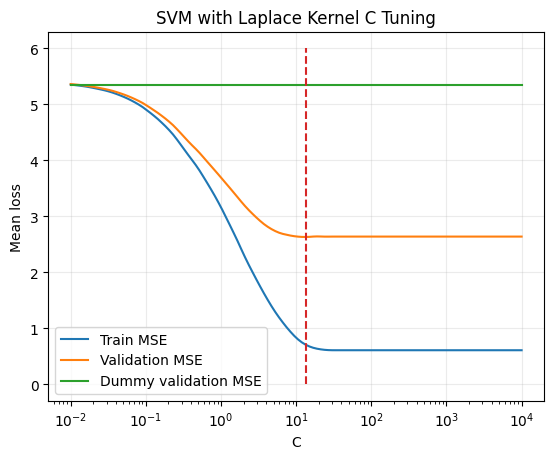

In [ ]:
plt.plot(cRange, trainHuberLoss, label="Train MSE")
plt.plot(cRange, validMSE, label="Validation MSE")
plt.plot([cRange[0],cRange[-1]], [dummyValidMSE, dummyValidMSE], label = "Dummy validation MSE")
plt.plot([best_C, best_C],[0,6], linestyle="dashed")
plt.legend(loc="lower left")
plt.xscale("log")
plt.grid(alpha = 0.25)
plt.title("SVM with Laplace Kernel C Tuning")
plt.xlabel("C")
plt.ylabel("Mean loss")

## Task (retrian on the entire training set)

In [ ]:
tunedLaplaceModel = SVR(kernel=laplacian_kernel, tol=1e-5, C=best_C, epsilon=1)

In [ ]:
tunedLaplaceResults = cross_validate(tunedLaplaceModel, train.drop("contamination_level", axis=1).to_numpy(), train["contamination_level"].values.ravel(), scoring = doubleScoring, return_train_score = True)
for key,value in tunedLaplaceResults.items():
    print(str(key) + ":", np.mean(value))

fit_time: 0.043611764907836914
score_time: 0.006611347198486328
test_neg_mean_squared_error: 2.631552304694453
train_neg_mean_squared_error: 0.7077891470399472
test_huber_loss_error: 1.0352708708644083
train_huber_loss_error: 0.34036041252190474


In [ ]:
tunedLaplaceModel.fit(train.drop("contamination_level", axis=1).to_numpy(), train["contamination_level"].values.ravel())

SVR(C=13.367506999197078, epsilon=1,
    kernel=<function laplacian_kernel at 0x7de869f4e950>, tol=1e-05)

## Q18

<ipython-input-35-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


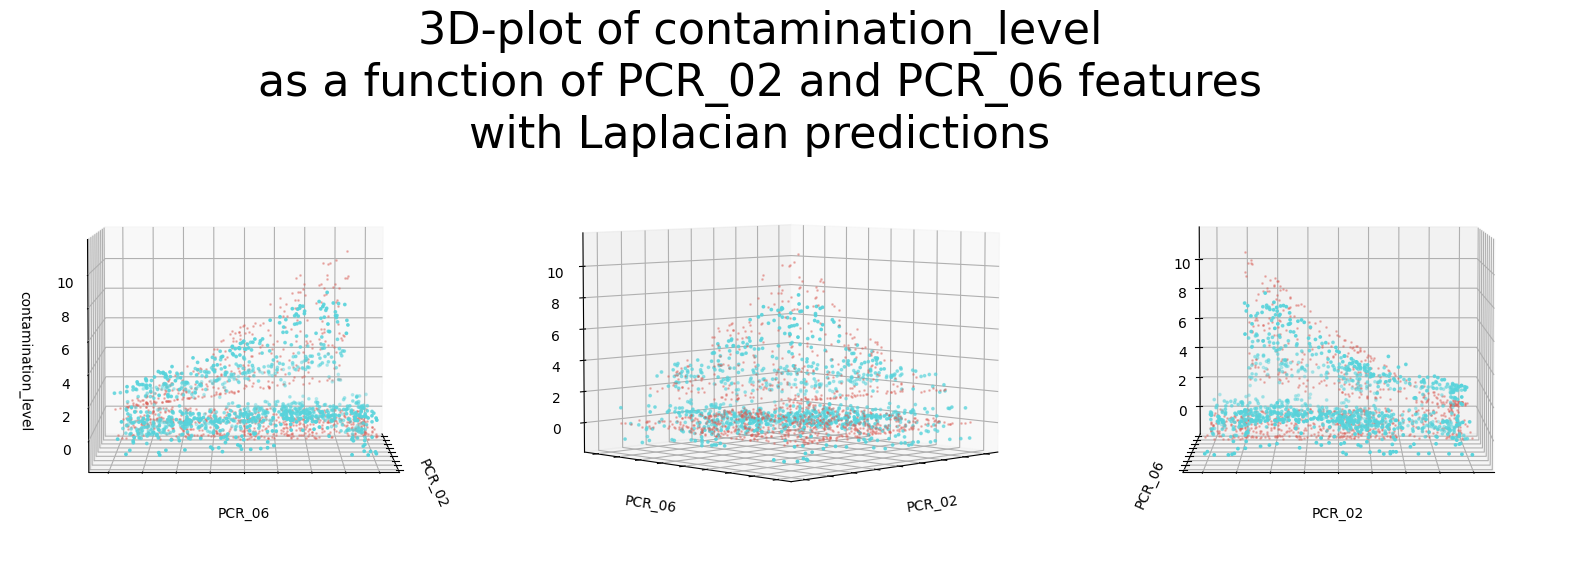

In [ ]:
laplacePredictions = tunedLaplaceModel.predict(train.drop("contamination_level", axis=1).to_numpy())
plot3d(train, "PCR_02", "PCR_06", "contamination_level", "3D-plot of contamination_level\nas a function of PCR_02 and PCR_06 features\nwith Laplacian predictions", laplacePredictions)

# Section 6: Testing your models

## Q20

In [ ]:
models = [ourDummy, tunedLinearModel, tunedRidgeLinearModel, tunedLaplaceModel]
for model in models:
  pred = model.predict(test.drop("contamination_level", axis = 1).to_numpy())
  mse = mean_squared_error(test["contamination_level"].values.ravel(), pred)
  print("Model", model,"\nScore:", mse)

Model DummyRegressor() 
Score: 4.9402701829860165
Model LinearRegressor(huber_delta=4.016874369391776, lr=0.03046989570903508) 
Score: 3.733213835291614
Model HuberRegressor(alpha=33, epsilon=4.016874369391776) 
Score: 3.672770641444407
Model SVR(C=13.367506999197078, epsilon=1,
    kernel=<function laplacian_kernel at 0x7de869f4e950>, tol=1e-05) 
Score: 2.4375257136325352


In [ ]:
from prettytable import PrettyTable, ALL

table = PrettyTable()
table.field_names = ["Model", "Score"]
table.hrules = ALL

for model in models:
    pred = model.predict(test.drop("contamination_level", axis=1).to_numpy())
    mse = mean_squared_error(test["contamination_level"].values.ravel(), pred)

    if type(model).__name__ == "Pipeline":
        model_name = "LaplaceRegressor"
    else:
        model_name = type(model).__name__

    table.add_row([model_name, mse])

print(table)

+-----------------+--------------------+
|      Model      |       Score        |
+-----------------+--------------------+
|  DummyRegressor | 4.9402701829860165 |
+-----------------+--------------------+
| LinearRegressor | 3.733213835291614  |
+-----------------+--------------------+
|  HuberRegressor | 3.672770641444407  |
+-----------------+--------------------+
|       SVR       | 2.4375257136325352 |
+-----------------+--------------------+
